# Inverted Pendulum

### Autorzy
- Eryk Mikołajek
- Jakub Kubicki
- Marcin Zub

In [1]:
import gymnasium as gym
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.distributions.normal import Normal
import gym
from gym import wrappers
import random
import keras
from keras import backend as k
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from main import REINFORCE, Policy_Network

In [2]:
!pip install 'gymnasium[mujoco]'

### Main.py

In [3]:
class Policy_Network(nn.Module):
    """Parametrized Policy Network."""

    def __init__(self, obs_space_dims: int, action_space_dims: int):
        """Initializes a neural network that estimates the mean and standard deviation
         of a normal distribution from which an action is sampled from.

        Args:
            obs_space_dims: Dimension of the observation space
            action_space_dims: Dimension of the action space
        """
        super().__init__()

        hidden_space1 = 16  # Nothing special with 16, feel free to change
        hidden_space2 = 32  # Nothing special with 32, feel free to change

        # Shared Network
        self.shared_net = nn.Sequential(
            nn.Linear(obs_space_dims, hidden_space1),
            nn.Tanh(),
            nn.Linear(hidden_space1, hidden_space2),
            nn.Tanh(),
        )

        # Policy Mean specific Linear Layer
        self.policy_mean_net = nn.Sequential(
            nn.Linear(hidden_space2, action_space_dims)
        )

        # Policy Std Dev specific Linear Layer
        self.policy_stddev_net = nn.Sequential(
            nn.Linear(hidden_space2, action_space_dims)
        )

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """Conditioned on the observation, returns the mean and standard deviation
         of a normal distribution from which an action is sampled from.

        Args:
            x: Observation from the environment

        Returns:
            action_means: predicted mean of the normal distribution
            action_stddevs: predicted standard deviation of the normal distribution
        """
        shared_features = self.shared_net(x.float())

        action_means = self.policy_mean_net(shared_features)
        action_stddevs = torch.log(
            1 + torch.exp(self.policy_stddev_net(shared_features))
        )

        return action_means, action_stddevs

In [4]:
class REINFORCE:
    """REINFORCE algorithm."""

    def __init__(self, obs_space_dims: int, action_space_dims: int, net: Policy_Network = None):
        """Initializes an agent that learns a policy via REINFORCE algorithm [1]
        to solve the task at hand (Inverted Pendulum v4).

        Args:
            obs_space_dims: Dimension of the observation space
            action_space_dims: Dimension of the action space
        """

        # Hyperparameters
        self.learning_rate = 1e-4  # Learning rate for policy optimization
        self.gamma = 0.99  # Discount factor
        self.eps = 1e-6  # small number for mathematical stability

        self.probs = []  # Stores probability values of the sampled action
        self.rewards = []  # Stores the corresponding rewards

        if net is None:
            self.net = Policy_Network(obs_space_dims, action_space_dims)
        else:
            self.net = net
        self.optimizer = torch.optim.AdamW(self.net.parameters(), lr=self.learning_rate)

    def sample_action(self, state: np.ndarray) -> float:
        """Returns an action, conditioned on the policy and observation.

        Args:
            state: Observation from the environment

        Returns:
            action: Action to be performed
        """
        state = torch.tensor(np.array([state]))
        action_means, action_stddevs = self.net(state)

        # create a normal distribution from the predicted
        #   mean and standard deviation and sample an action
        distrib = Normal(action_means[0] + self.eps, action_stddevs[0] + self.eps)
        action = distrib.sample()
        prob = distrib.log_prob(action)

        action = action.numpy()

        self.probs.append(prob)

        return action

    def update(self):
        """Updates the policy network's weights."""
        running_g = 0
        gs = []

        # Discounted return (backwards) - [::-1] will return an array in reverse
        for R in self.rewards[::-1]:
            running_g = R + self.gamma * running_g
            gs.insert(0, running_g)

        deltas = torch.tensor(gs)

        loss = 0
        # minimize -1 * prob * reward obtained
        for log_prob, delta in zip(self.probs, deltas):
            loss += log_prob.mean() * delta * (-1)

        # Update the policy network
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Empty / zero out all episode-centric/related variables
        self.probs = []
        self.rewards = []

In [5]:
def train_agent():
    # env = gym.make("InvertedPendulum-v5", render_mode="human")
    env = gym.make("InvertedPendulum-v5")
    wrapped_env = gym.wrappers.RecordEpisodeStatistics(env, 50)

    total_num_episodes = int(8e3)  # Total number of episodes
    # Observation-space
    obs_space_dims = env.observation_space.shape[0]
    # Action-space
    action_space_dims = env.action_space.shape[0]


    seed = 3  # best results

    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

    # Reinitialize agent every seed
    agent = REINFORCE(obs_space_dims, action_space_dims)
    reward_over_episodes = []

    for episode in range(total_num_episodes):
        # gymnasium v26 requires users to set seed while resetting the environment
        obs, info = wrapped_env.reset(seed=seed)

        done = False
        while not done:
            action = agent.sample_action(obs)

            # Step return type - `tuple[ObsType, SupportsFloat, bool, bool, dict[str, Any]]`
            # These represent the next observation, the reward from the step,
            # if the episode is terminated, if the episode is truncated and
            # additional info from the step
            obs, reward, terminated, truncated, info = wrapped_env.step(action)
            agent.rewards.append(reward)

            # End the episode when either truncated or terminated is true
            #  - truncated: The episode duration reaches max number of timesteps
            #  - terminated: Any of the state space values is no longer finite.
            done = terminated or truncated

        reward_over_episodes.append(wrapped_env.return_queue[-1])
        agent.update()

        if episode % 1000 == 0:
            avg_reward = int(np.mean(wrapped_env.return_queue))
            print("Episode:", episode, "Average Reward:", avg_reward)

    torch.save(agent.net.state_dict(), "best_model2.pt")

    df1 = pd.Series(reward_over_episodes)
    df1.plot(title="Learning curve", xlabel="episodes", ylabel="reward")
    plt.savefig('learning_curve.png')

### PoleCart.py

In [6]:
'''
NOTE
action:
0 for left 
1 for right
'''
checkpoint = ModelCheckpoint('model/model_dnn.keras', monitor='val_loss', verbose=1, save_best_only=True)
no_of_observations = 500
min_score = 100

In [7]:
# generate the training data
def generate_training_data(no_of_episodes):
    print('generating training data')
    # initize the environment
    env = gym.make('CartPole-v1').env
    X = []
    y = []
    left = 0
    right = 0

    for i_episode in range(no_of_episodes):
        prev_observation = env.reset()
        score = 0
        X_memory = []
        y_memory = []
        for t in range(no_of_observations):
            action = random.randrange(0, 2)

            ## debugging code
            '''
            if action == 0:
                left = left + 1
            else:
                right = right + 1
            '''
            new_observation, reward, done, info, _ = env.step(action)
            score = score + reward
            X_memory.append(prev_observation)
            y_memory.append(action)
            prev_observation = new_observation
            if done:
                if score > min_score:
                    for data in X_memory:
                        X.append(data)
                    for data in y_memory:
                        y.append(data)
                    print('episode : ', i_episode, ' score : ', score)
                break
        env.reset()
    # debugging code
    '''
    print('left : ', left)
    print('right: ',right)
    '''
    # converting them into numpy array
    X = np.asarray(X)
    y = np.asarray(y)

    # saving the numpy array
    np.save('data/X', X)
    np.save('data/y', y)

    # printing the size
    print('shape of X: ', X.shape)
    print('shape of target labels', y.shape)

In [8]:
def get_model():
    model = Sequential()
    model.add(Dense(128, input_dim=4))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(.5))

    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(.5))

    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(.5))

    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(.5))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.summary()
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
    return model

In [9]:
def train_model(model):
    # loading the training data from the disk
    X = np.load('data/X.npy')
    y = np.load('data/y.npy')
    # making train test split 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
    print('X_train: ', X_train.shape)
    print('y_train:', y_train.shape)
    print('X_test: ', X_test.shape)
    print('y_test: ', y_test.shape)
    # training the model
    model.fit(X_train, y_train, validation_data=[X_test, y_test], verbose=1,
              callbacks=[checkpoint],
              epochs=20, batch_size=10000, shuffle=True)
    # returns the model
    return model

In [10]:
def testing(model):
    # model = load_model('model/model.h5')
    env = gym.make('CartPole-v1').env
    env = wrappers.Monitor(env, 'nn_files', force=True)
    observation = env.reset()
    no_of_rounds = 10
    max_rounds = no_of_rounds
    min_score = 1000000
    max_score = -1
    avg_score = 0

    # playing a number of games
    while (no_of_rounds > 0):
        # initial score
        score = 0
        action = 0
        prev_obs = []
        while (True):
            env.render()
            if len(prev_obs) == 0:
                action = random.randrange(0, 2)
            else:
                data = np.asarray(prev_obs)
                data = np.reshape(data, (1, 4))
                output = model.predict(data)
                # checking if the required action is left or right
                if output[0][0] >= .5:
                    action = 1
                elif output[0][0] < .5:
                    action = 0

            new_observation, reward, done, info = env.step(action)
            prev_obs = new_observation
            # calculating total reward
            score = score + reward

            if done:
                # if the game is over
                print('game over!! your score is :  ', score)
                if score > max_score:
                    max_score = score
                elif score < min_score:
                    min_score = score
                avg_score += score
                env.reset()
                break
        no_of_rounds = no_of_rounds - 1
        # stats about scores 
        if no_of_rounds == 0:
            print('avg score : ', avg_score / max_rounds)
            print('max score: ', max_score)
            print('min score: ', min_score)

In [14]:
generate_training_data(50000)
model = get_model()
model = train_model(model)
testing(model)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 128)            │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_16 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │           129 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_17 (Activation)      │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,601 (1.26 MB)

 Trainable params: 329,601 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

### Visualize_best_model.py

In [ ]:
path = 'best_model.pt'

env = gym.make("InvertedPendulum-v4", render_mode="human")
wrapped_env = gym.wrappers.RecordEpisodeStatistics(env, 50)
obs_space_dims = env.observation_space.shape[0]
action_space_dims = env.action_space.shape[0]

net_loaded = Policy_Network(obs_space_dims, action_space_dims)
net_loaded.load_state_dict(torch.load(path))
agent = REINFORCE(obs_space_dims, action_space_dims, net_loaded)

observation, info = env.reset()

while True:
    action = agent.sample_action(observation)
    observation, reward, terminated, truncated, info = wrapped_env.step(action)

    if terminated:# or truncated:
        break
        # observation, info = env.reset()

env.close()

## Learning curve for the best model

In [19]:
import cv2

Text(0.5, 1.0, 'Learning Curve - Discount Factor 0.99')

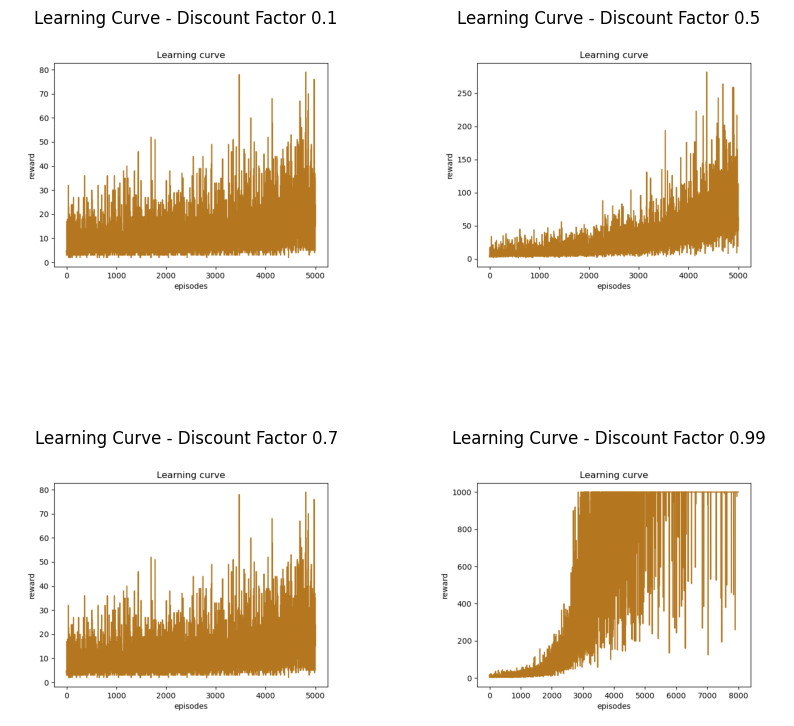

: 

In [24]:
learning_curve_df1 = cv2.imread('learning_curve_df_01.png')
learning_curve_df5 = cv2.imread('learning_curve_df_05.png')
learning_curve_df7 = cv2.imread('learning_curve_df_07.png')
learning_curve = cv2.imread('learning_curve.png')

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].imshow(learning_curve_df1)
axs[0, 0].axis('off')
axs[0, 0].set_title('Learning Curve - Discount Factor 0.1')
axs[0, 1].imshow(learning_curve_df5)
axs[0, 1].axis('off')
axs[0, 1].set_title('Learning Curve - Discount Factor 0.5')
axs[1, 0].imshow(learning_curve_df7)
axs[1, 0].axis('off')
axs[1, 0].set_title('Learning Curve - Discount Factor 0.7')
axs[1, 1].imshow(learning_curve)
axs[1, 1].axis('off')
axs[1, 1].set_title('Learning Curve - Discount Factor 0.99')
